# Test

In [4]:
import vmamba as vm
model_pre = vm.vmamba_tiny_s1l8(pretrained=True)
print(sum(p.numel() for p in model_pre.parameters()))

30249064


In [2]:
from datasets import load_dataset

ds = load_dataset("timm/mini-imagenet")

In [5]:
import numpy as np
print(ds['train'][0])
print(np.array(ds['train'][0]['image']).transpose(2,0,1).shape)

{'image': <PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=357x500 at 0x7F5732E0A2C0>, 'label': 0}
(3, 500, 357)


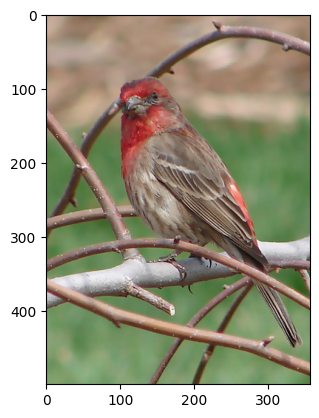

In [80]:
import matplotlib.pyplot as plt

plt.imshow(ds['train'][0]['image'])
plt.show()

In [31]:
import torch

print(torch.tensor(np.array(ds['train'][0]['image']).transpose(2,0,1)).type())
y_pred = model_pre(torch.tensor(np.array(ds['train'][0]['image']).transpose(2,0,1), dtype=torch.float32).unsqueeze(0))
print(torch.argmax(y_pred))
print(ds['train'][0]['label'])

torch.ByteTensor
tensor(12)
0


# Mod

In [1]:
import torch 

device = 'cuda:0' if torch.cuda.is_available() else 'cpu'
torch.cuda.set_device(device)
print(device)

cuda:0


In [2]:
from datasets import load_dataset

ds = load_dataset("timm/mini-imagenet")

/home/bcs/miniconda3/envs/vmamba/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [3]:
import vmamba as vm
# model = vm.vmamba_tiny_s1l8()
model = vm.vmamba_itty().cuda()
print(sum(p.numel() for p in model.parameters()))
print(next(model.parameters()).device)

1274980
cuda:0


In [4]:
class ImgLoader():

    def __init__(self, data, batch_size=50):
        self.size = len(data)
        # data_X = [np.array(d['image']) for d in data]
        self.data_X = torch.tensor(np.array(data['image']), dtype=torch.float32).transpose(1,-1).cuda()
        self.data_y = torch.tensor(data['label'], dtype=torch.long).cuda()
        self.batch_size = batch_size
        self.it = 0

    def __iter__(self):
        return self

    def __next__(self):
        # batch = np.random.choice(self.data, size=self.batch_size)
        # id = np.random.randint(0, high=len(self.data_X), size=self.batch_size)
        # return torch.tensor(np.array(self.data_X[id]), dtype=torch.float32).transpose(0,2),\
        #        torch.tensor(self.data_y[id], dtype=torch.float16)
        # print(self.data_X.shape)\
        if (self.it >= self.size):
            print('stop')
            raise StopIteration
        
        batch = (self.it + torch.linspace(0, self.batch_size-1, self.batch_size)).type(torch.int)
        self.it += 1
        # print(batch)
        return self.data_X[batch], self.data_y[batch]

In [5]:
import numpy as np

ids = np.random.rand(10)
training_loader = ImgLoader(ds['train'][ids], batch_size=1)
input, label = training_loader.__next__()
print(torch.argmax(model(input)))
print(label)

HERE
torch.Size([1, 48, 90, 125])
torch.Size([1, 48, 90, 125])
torch.Size([16, 48, 90, 125])


RuntimeError: The expanded size of the tensor (1) must match the existing size (16) at non-singleton dimension 0.  Target sizes: [1, 48, 11250].  Tensor sizes: [16, 48, 11250]

In [7]:
import torch
from torch import nn
import numpy as np

optimizer = torch.optim.AdamW(model.parameters())
loss_fn = nn.CrossEntropyLoss()

ids = np.random.rand(10)
training_loader = ImgLoader(ds['train'][ids], batch_size=2)
# print(training_loader.__next__())

def train_one_epoch(epoch_index, tb_writer=None):
    running_loss = 0.
    last_loss = 0.

    # Here, we use enumerate(training_loader) instead of
    # iter(training_loader) so that we can track the batch
    # index and do some intra-epoch reporting
    for i, data in enumerate(training_loader):
        print(f"{i}: ", end="")
        # Every data instance is an input + label pair
        inputs, labels = data
        print(f"{inputs.shape}, {labels[i]}, ", end="")

        # Zero your gradients for every batch!
        optimizer.zero_grad()

        # Make predictions for this batch
        print('forward, ', end="")
        outputs = model(inputs)

        # Compute the loss and its gradients
        print('back, ', end="")
        loss = loss_fn(outputs, labels)
        loss.backward()

        # Adjust learning weights
        print('step')
        optimizer.step()

        # Gather data and report
        running_loss += loss.item()
        if tb_writer is not None and i % 1000 == 999:
            last_loss = running_loss / 1000 # loss per batch
            print('  batch {} loss: {}'.format(i + 1, last_loss))
            tb_x = epoch_index * len(training_loader) + i + 1
            tb_writer.add_scalar('Loss/train', last_loss, tb_x)
            running_loss = 0.

    return last_loss

for i in range(1):
    print(f"Epoch {i}")
    train_one_epoch(i, )

Epoch 0
0: torch.Size([2, 3, 357, 500]), 0, forward, back, step
1: torch.Size([2, 3, 357, 500]), 0, forward, back, step
stop


In [53]:
# from scurve.hilbert import hilbert_point
# # import hilbert as hil
# # print()
# a=2
# b=2
# ten = torch.arange(a*b).reshape((a,b)).cuda()
# # print(ten)
# print(encode_hilbert(ten/(a*b), 1))

ModuleNotFoundError: No module named 'utils'

In [24]:
import pathing
import torch
import numpy as np

# hcurve = torch.tensor([0, 1, 5, 4, 
#                        8, 12, 13, 9, 
#                        10, 14, 15, 11, 
#                        7, 6, 2, 3])
hcurve = torch.tensor([0, 1, 14, 15, 
                       3, 2, 13, 12, 
                       4, 7, 8 , 11,
                       5, 6, 9 , 10])

# print(torch.argsort(hcurve).reshape(4,4))

ten = torch.arange(0, 32).reshape((2,4,4))
print(ten)
hten = pathing.sort_by_indices(ten.flatten(), torch.argsort(hcurve)).reshape(4,4)
print(hten)
print(pathing.sort_by_indices(hten.flatten(), hcurve).reshape(4,4))

tensor([[[ 0,  1,  2,  3],
         [ 4,  5,  6,  7],
         [ 8,  9, 10, 11],
         [12, 13, 14, 15]],

        [[16, 17, 18, 19],
         [20, 21, 22, 23],
         [24, 25, 26, 27],
         [28, 29, 30, 31]]])
tensor([[ 0,  1,  5,  4],
        [ 8, 12, 13,  9],
        [10, 14, 15, 11],
        [ 7,  6,  2,  3]])
tensor([[ 0,  1,  2,  3],
        [ 4,  5,  6,  7],
        [ 8,  9, 10, 11],
        [12, 13, 14, 15]])


([(0.0, 0.0), (1.0, 0.0), (1.0, 1.0), (0.0, 1.0), (0.0, 2.0), (1.0, 2.0), (2.0, 2.0), (3.0, 2.0), (3.0, 1.0), (2.0, 1.0), (2.0, 0.0), (3.0, 0.0), (4.0, 0.0), (4.0, 1.0), (4.0, 2.0), (5.0, 2.0), (6.0, 2.0), (6.0, 1.0), (5.0, 1.0), (5.0, 0.0), (6.0, 0.0), (7.0, 0.0), (7.0, 1.0), (7.0, 2.0), (7.0, 3.0), (7.0, 4.0), (7.0, 5.0), (6.0, 5.0), (5.0, 5.0), (5.0, 4.0), (6.0, 4.0), (6.0, 3.0), (5.0, 3.0), (4.0, 3.0), (4.0, 4.0), (4.0, 5.0), (3.0, 5.0), (2.0, 5.0), (2.0, 4.0), (3.0, 4.0), (3.0, 3.0), (2.0, 3.0), (1.0, 3.0), (0.0, 3.0), (0.0, 4.0), (1.0, 4.0), (1.0, 5.0), (0.0, 5.0), (0.0, 6.0), (0.0, 7.0), (1.0, 7.0), (1.0, 6.0), (2.0, 6.0), (2.0, 7.0), (3.0, 7.0), (3.0, 6.0), (4.0, 6.0), (4.0, 7.0), (4.0, 8.0), (3.0, 8.0), (2.0, 8.0), (1.0, 8.0), (0.0, 8.0), (0.0, 9.0), (0.0, 10.0), (0.0, 11.0), (1.0, 11.0), (1.0, 10.0), (1.0, 9.0), (2.0, 9.0), (2.0, 10.0), (2.0, 11.0), (3.0, 11.0), (3.0, 10.0), (3.0, 9.0), (4.0, 9.0), (4.0, 10.0), (4.0, 11.0), (5.0, 11.0), (6.0, 11.0), (7.0, 11.0), (7.0, 10.0), 

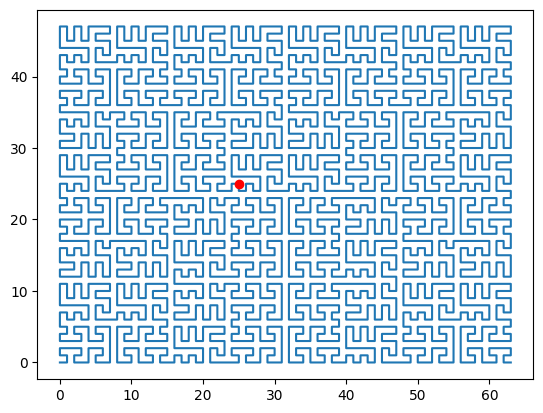

In [30]:
import spacefill.curvetools as ct


# curve_map = ct.generate_map(90, 125)
curve_map = ct.generate_map(64, 48)
# print('Byte Size: {}'.format(sys.getsizeof(curve_map)))
# print('Amount of points: {}'.format(len(curve_map)))

point = ct.coord_to_position((25, 25), curve_map)
coord = ct.position_to_coord(point, curve_map)

import matplotlib.pyplot as plt
print(curve_map)
print(list(zip(*(curve_map[0][:10]))))
px, py = list(zip(*curve_map[0]))
plt.plot(px, py)
plt.plot([coord[0]], [coord[1]], 'ro')
plt.show()